# Performance Metrics for Classification 
Note: This notebook is adapted from [Geron's chapter 3 notebook](https://github.com/ageron/handson-ml3/blob/main/03_classification.ipynb) in accordance with the [Apache v2 License](https://github.com/ageron/handson-ml3/blob/main/LICENSE).

This notebook is intended for _active learning_. As a student, please run the cells as we go over them in class, and answer the questions (marked with "_to the student_") in a new cell just below each question. Also, you are invited to take notes. Once you're done, you can commit and push this updated notebook to your repository, such that you could have a copy that includes all of your changes.

### Classification

To define classification let's look at the relevant [Wikipedia article](([Wikipedia](https://en.wikipedia.org/wiki/Statistical_classification))):

>In statistics and machine learning, classification is the problem of identifying which of a set of categories (sub-populations) an observation (or observations) belongs to. Examples are assigning a given email to the "spam" or "non-spam" class, and assigning a diagnosis to a given patient based on observed characteristics of the patient (sex, blood pressure, presence or absence of certain symptoms, etc.).

>Often, the individual observations are analyzed into a set of quantifiable properties, known variously as explanatory variables or features. These properties may variously be categorical (e.g. "A", "B", "AB" or "O", for blood type), ordinal (e.g. "large", "medium" or "small"), integer-valued (e.g. the number of occurrences of a particular word in an email) or real-valued (e.g. a measurement of blood pressure). Other classifiers work by comparing observations to previous observations by means of a similarity or distance function.

>An algorithm that implements classification, especially in a concrete implementation, is known as a classifier. The term "classifier" sometimes also refers to the mathematical function, implemented by a classification algorithm, that maps input data to a category.

A list of classification algorithms can be seen on a second [Wikipedia](https://en.wikipedia.org/wiki/Category:Classification_algorithms) article.

**To the student**: summarize in your own words, based on the Wikipeida content quoted above, and potentially additional sources:
* What are we trying to solve in a classification problem?
* What is a classifier?

In this notebook, we will explore the evaluation of classifiers, rather than understanding how classifier are trained and make predictions. Evaluation of classifiers can be done by quantitative measures, often called _performance metrics_. We will look at the most common ones in this notebook. 

First let's load all of the libraries that will be used as part of this notebook:

In [1]:
import numpy as np

# plotting modules
from matplotlib import pyplot as plt
import matplotlib.patches as patches  # for curved arrows
import seaborn as sns

# The web source of the MNIST dataset that we will work with
from sklearn.datasets import fetch_openml

# The classifiers we will use in this notebook
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

# cross validation functions
from sklearn.model_selection import cross_validate, cross_val_predict

# performance metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score


## Obtaining the Data
For a review about MNIST and `openml`, see the notebook about MNIST.
> class_notebooks/datasets/mnist.ipynb

MNIST stands for **Modified National Institute of Standards and Technology database**.

The MNIST dataset is a large collection of 70,000 grayscale images of handwritten digits, from 0 to 9. It's split into a training set of 60,000 images and a testing set of 10,000 images. Each image is 28x28 pixels. It's a foundational dataset for machine learning.

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

X = mnist.data: This line assigns the features of the MNIST dataset to the variable X. For MNIST, the "data" consists of the pixel values for each of the 70,000 images. Each image is 28x28 pixels, which means each row in X represents one image, containing 784 pixel intensity (i.e., Grayscale: [0=black...255=white]) values (28 * 28 = 784). X is the input that a machine learning model will use to learn.

y = mnist.target: This line assigns the labels (or targets) to the variable y. Each entry in y corresponds to a row in X and represents the actual digit (from '0' to '9') depicted in that image. This is the "ground truth" or the correct answer that the model aims to predict.

In [3]:
X = mnist.data
y = mnist.target

In [4]:
X[25001]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         6, 122, 244, 255, 225,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 150, 253, 253, 162,  31,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [5]:
y[25001]

'4'

In [6]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

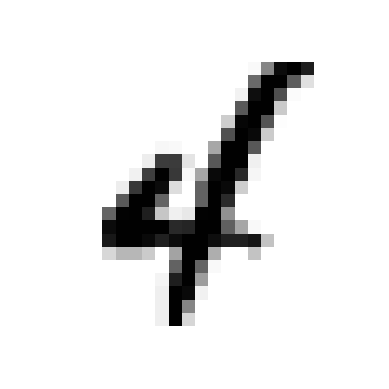

In [7]:
some_digit = X[25001]  # here we are using the first image in the dataset
plot_digit(some_digit)
plt.show()

In [8]:
y[0]  # the label for the first image

'5'

## Preprocessing the Data

Now, after we are familiar with the data, we can move towards preprocessing it for training. Preprocessing can include augmenting it (adding artificially similar samples, based on the existing ones), scaling it, removing outliers and such. Here we just divide the data into a train and test set, and create a new set of labels, such that the classification becomes binary, instead of 10-fold.

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [11]:
y_train_5[:5]

array([ True, False, False, False, False])

In [12]:
y_test_5[:5]

array([False, False, False, False, False])

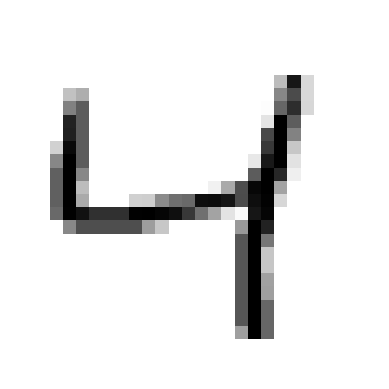

In [13]:
some_digit = X[2]  # here we are using the third image in the dataset
plot_digit(some_digit)
plt.show()

**To the student**: 
* What does the Boolean values (`True` and `False`) stand for in the target `y_train_5`?
* Why wasn't `X` changed as well?

The target of the preprocesing is to transform a multiclass classification problem into a simpler binary classification problem.

- **Original Problem (Multiclass)**: Your original y_train and y_test arrays contain labels for ten different classes (the digits '0' through '9'). The goal of a model trained on this data would be to distinguish between all ten digits.
- **Solution (Single class)**: Create new target arrays (y_train_5 and y_test_5). Instead of containing multiple digit labels, these new arrays contain only boolean values:

> True: if the original digit in y_train or y_test was a '5'. <br/>
> False: if the original digit was anything else (i.e., '0', '1', '2', '3', '4', '6', '7', '8', or '9').

The main purpose is to simplify the task. You are no longer asking the model "Which of the 10 digits is this?". Instead, you are asking a much more focused question: "Is this digit a 5, or not?"

## Training a Model

Here we are using the stochastic gradient descent classifier ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)). It provides SGD training of linear classifiers (SVM, logistic regression, etc.). However, we will not focus in this notebook on _how_ the classifer works internally, but on how well it performs. 

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


#### Core Model & Regularization
These parameters define the mathematical foundation of your model.

- **loss='hinge'**: The loss function is what the model tries to minimize during training. 'hinge' is the classic loss function for a linear Support Vector Machine (SVM). So, by default, your SGDClassifier is effectively training a linear SVM classifier.
- **penalty='l2'**: The penalty (or regularization) term is used to prevent overfitting, where the model learns the training data too well but fails on new data. 'l2' is the most common penalty, which encourages the model's internal weights to be small and distributed, leading to a simpler, more robust model.
- **alpha=0.0001**: This controls the strength of the regularization penalty. A smaller alpha means less regularization, while a larger alpha means stronger regularization.

#### Learning Process & Stopping Criteria
These parameters control how the model learns and when it should stop.

- **max_iter=1000**: This is the maximum number of epochs, or passes, over your entire training data. The model will stop after 1000 passes, even if it hasn't perfectly converged. This is a safeguard to prevent it from running indefinitely.
- **tol=0.001**: The tolerance. This is a smarter stopping criterion. Training will stop if the improvement in the loss function is less than this value for n_iter_no_change consecutive epochs.
- **learning_rate='optimal'**: This is a crucial setting. The learning rate determines the size of the steps the model takes to minimize the loss function. 'optimal' means scikit-learn will use a specific formula to automatically determine a good learning rate, so you don't have to set it manually.

#### Reproducibility & Execution
These parameters are about the operational aspects of the training process.

- **random_state=42**: This is the parameter you set yourself. Because the algorithm has a "stochastic" (random) element (specifically, shuffling the data), setting a random_state ensures that the exact same sequence of random numbers is used every time you run the code. This makes your results reproducible, which is essential for testing and debugging.
- **shuffle=True**: This confirms that the training data is shuffled before each epoch (pass). This is critical for SGD, as it prevents the model from being biased by the order of the training examples.
- **n_jobs=None**: This specifies how many CPU cores to use for the task. None typically means using just one core. You could set this to -1 to use all available cores and potentially speed up training.

Let's use this classifier to predict whether `some_digit` is in the **positive** or in the **negative** class.

In [15]:
sgd_clf.predict([some_digit])

array([False])

To the student: 
* Which image does `some_digit` stand for? (scroll above if needed)
* What is the meaning of the resulting Boolean value (`True` and `False`)?

## Evaluating the Model

### Accuracy

Let's start with `accuracy` as a performance metric. In `sklearn`, a performance metric is also known as `scoring metric`, and its value as `score`.

`Accuracy` is the ratio between correct perdictions to all predictions ([Wikipedia](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification)). 

$accuracy = \frac{correct\ classifications}{all\ classifications}$

In our case, the accuracy is calculated over the test set for each of the **cross validation folds**.

👉 What is a cross-validation fold? Research it!

Aaccuracy, like other performance metrics, can be calculated on any part of the complete dataset, including the traning set. So whenever we report about its value, it is informative to mention on which part of the dataset it was calculated on. 

Some optional `sklearn` resources about accuracy:

https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

In [16]:
cross_validate(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3, scoring="accuracy")

{'fit_time': array([7.70162392, 7.0294292 , 5.47465801]),
 'score_time': array([0.08585548, 0.03774095, 0.03469849]),
 'test_score': array([0.95035, 0.96035, 0.9604 ])}

**To the student**: Regarding the `cross validate` function, browse the sklearn's [docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) for `cross_validate``:
* Describe in your own words what the `cv` argument is for.
* How many times has the model been trained?
* How is the value of `cv` related to the output of this function?
* What do `fit_time`,  `score_time` and `test_score` stand for?

**To the student**: Regrading the accuracy
* Could you provide a textual description of the accuracy result for the first fold? For instance "out of 100 digits, XYZ were correctly predicted, while ZYX were incorrectly predicted"
* Given the uniform distirbution of samples across all 10 digits, and given that the classifier classify one of them versus all the others (`5` versus all others in our case), what would be a simple handwritten rule to achieve 90% accuracy?
* How would you describe the goodness of classification of the `SGDClassifier` versus the expected accuracy of such a handwritten rule? Please describe it in a sentence or two. 


**Answers**
- Describe in your own words what the cv argument is for.
> The cv argument defines the cross-validation strategy. cv=3 splits your training data into 3 equal parts, or "folds". It then uses two folds for training and one for testing, rotating which fold is used for testing until each has been used once. This gives a more reliable measure of your model's performance.

- How many times has the model been trained?
> The model has been trained 3 times, once for each of the cross-validation folds.

- How is the value of cv related to the output of this function?
> The value of cv determines the number of elements in the output arrays. Since cv=3, the output dictionary will contain arrays with 3 values each—one result from each of the 3 validation runs.

- What do the three arrays, fit_time, score_time and test_score stand for?
    - `fit_time`: The time spent training the model for each cross-validation fold.
    - `score_time`: This is an array with the time (in seconds) it took to calculate the test_score for each fold. It measures only the prediction/evaluation time, not the training time.
    - `test_score`: This is an array with the accuracy scores for each of the 3 folds. It shows how well the model performed on the validation data in each run.


Following your answer to Let's look at a classifier that _ignores the features_, And see how well it will do. [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) makes predictions that ignore the input features. It is trained by guessing the next label, based on the labels it has seen so far, but without any considerations of the features (see its docs). Let's train it:

In [17]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)  # X are being ignored, see docs

,"strategy strategy: {""most_frequent"", ""prior"", ""stratified"", ""uniform"", ""constant""}, default=""prior""Strategy to use to generate predictions.* ""most_frequent"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit`. The `predict_proba` method returns the matching one-hot encoded vector.* ""prior"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit` (like ""most_frequent""). ``predict_proba`` always returns the empirical class distribution of `y` also known as the empirical class prior distribution.* ""stratified"": the `predict_proba` method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The `predict` method returns the class label which got probability one in the one-hot vector of `predict_proba`. Each sampled row of both methods is therefore independent and identically distributed.* ""uniform"": generates predictions uniformly at random from the list of unique classes observed in `y`, i.e. each class has equal probability.* ""constant"": always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class. .. versionchanged:: 0.24 The default value of `strategy` has changed to ""prior"" in version 0.24.",'prior'
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness to generate the predictions when``strategy='stratified'`` or ``strategy='uniform'``.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"constant constant: int or str or array-like of shape (n_outputs,), default=NoneThe explicit constant as predicted by the ""constant"" strategy. Thisparameter is useful only for the ""constant"" strategy.",None


Let's see what is the accuracy of the dummy classifier:

In [18]:
cross_validate(estimator=dummy_clf, X=X_train, y=y_train_5, cv=3, scoring="accuracy")

{'fit_time': array([0.12989521, 0.09088922, 0.0923624 ]),
 'score_time': array([0.00231767, 0.00102019, 0.00217056]),
 'test_score': array([0.90965, 0.90965, 0.90965])}

**To the student**: 
* What is the accuracy of the `DummyClassifier`? 
* How does it compare to the handwritten rule you suggested above, and to the `SGDClassifier`? 

Let's dive deeper: 
How does the Dummy Classifier makes its perdictions? 
Well, the Dummy Classifier always returns `False`, that is it is always predicting that the digit is not `5`:

In [19]:
dummy_clf.predict(X_train)[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

In [20]:
# `any` is a Python function that returns True if any element of the iterable is true
print(any(dummy_clf.predict(X_train)))
print(any(dummy_clf.predict(X_test)))

False
False


**This example shows that while `accuracy` is a useful metric, it only reveals one aspect of the model performance. Additional metrics should be utilized for a more complete view.**

**To the student**: 
## Exercise - Fashion-MNIST data set

Follow the same process we used to analyze the MNIST data set, but this time do it using the **Fashion-MNIST** data set.

- Get the data set (code cell below)
- Preprocess the data set
- Train a model
- Evaluate the model

> Are you able to replicate the process? Provide your insights.

In [21]:
from sklearn.datasets import fetch_openml

# Fetch the Fashion-MNIST dataset from OpenML
fashion_mnist = fetch_openml('Fashion-MNIST', as_frame=False, parser='auto')

# The data is now in the same Bunch object format
# X will contain the pixel data, y will contain the labels
X_fashion = fashion_mnist.data
y_fashion = fashion_mnist.target

### Confusion Matrix

In the field of machine learning and specifically the problem of classification, a confusion matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix).

To understand what a confusion matrix is, it is useful to start with an example. Wikipedia provides us with a [good one](https://en.wikipedia.org/wiki/Confusion_matrix), let's go over it together...


In a binary classification, for a single prediction of one sample, there are 4 possible options for the prediction with respect to the _target label_ (`5` in our example, the target can be chosen from the two labels, based on our interest, based for instance on the main objective of the classifier):

The positive class is one of the two classes in a binary classification problem. **It is the class that the model is trying to predict**. The choice of which class is considered positive and which is considered negative is often arbitrary and depends on the context of the problem. For example, in a medical test for a disease, the positive class could be “disease present” and the negative class could be “disease not present”.

There are two types of correct predictions:
* **True Positive** - the prediction is of the target class, and that is correct (according to the ground truth). 
* **True Negative** - the prediction is not of the target class, and this is correct.

There are two types of incorrect predictions:
* **False Positive** - the prediction is of the target class, and this is incorrect (according to the ground truth).
* **False Negative** - the prediction is not of the target class, and this is incorrect

The confusion matrix is a table:
* Each row stands for an actual label (going over all labels in the dataset, one row per label)
* Each column stands for a predicted label (going over all labels in the dataset, one row per label)
* Each cell in the table simply counts the number of samples in the dataset that had such a predicted-actual combination. This can be augmented by a percentage, where this number is divided by the total number of samples in the dataset.

In `sklearn`, the default order of the labels in the confusion matrix is based on a sort over all unique labels in both the ground-truth and prediction labels (see the `labels` parameter in the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)).

Note that to generate a confusion table, one need to know only the prediction and actual labels of a given dataset. The classifier that generated this predictions may be deemed irrelevant for the generation of the matrix.

In [22]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
y_train_pred.shape

(60000,)

In [24]:
y_train_pred[:10]

array([ True, False, False, False, False, False, False, False, False,
       False])

In [25]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [26]:
cm.sum()

np.int64(60000)

To better understand confusion matrix, let's generate perfect dummy predictions:

In [27]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

To the student: Using `sklearn` resources about Confusion Matrix: [docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and [user guide](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix):

* What are the required arguments that the `confusion_matrix` function expects?
* What is the output of this function, specifically for a binary classifier such as the one tested here?
* What is the meaning of each value in both of the confusion matrics returned above?

### Precision and Recall

In classification, precision and recall are additional performance metrics ([Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)).
They are calculated and presented with respect to the 'class of interest'. This class can be any one that we are interested in calculating precision and recall for. It depends on the success criteria that we have defined for the model. For instance, if the model should identify a risk of an illness based on a medical test results, the class of interest would probably be existence of such medical condition. We call this class of interest as the _positive class_. 

* **Precision** is ratio of the number of correctly labelled positive samples, out of all samples labelled as positive samples. It tells us how precise the model is in predicting a positive class. This is equal to: $Precision = \frac{True \ Positives}{True \ Positives + False \ Positives}$. 

* **Recall** (also known as sensitivity) is the number of correctly labelled positive samples, out of all positive samples in the test dataset $Recall = \frac{True \ Positives}{True \ Positives + False \ Negatives}$. It tells us how many samples of the 'class of interest' the model is able to identify, out of all samples. That is, how many it is able to recall. In the search relevnce jargon, this is described as the ratio of relevant instances that were retrieved, but the formula is the same.



Here is another example of Precision and Recall, based on the MNIST data set we explored before.

**"Imagine a program designed to find all images of the digit '7' (the relevant element) from a folder of handwritten digits.**

- We give the program a folder containing 30 images: 10 of them are the digit '7', and 20 are other digits.
- After running, the program reports that it found the digit '7' in 8 images.

By checking its work, we see that:

- Of the 8 images it identified as a '7', 6 are actually '7's (true positives).
- The other 2 are actually other digits that it mistook for a '7' (false positives).
- It completely missed 4 of the '7's that were in the folder (false negatives).
- Finally, 18 other digits were correctly identified as not being a '7' (true negatives).

**The program's precision is then 6/8 (true positives / all selected images).**

> Think of it this way: "When the program predicts an image is a '7', how often is it right?"

**The program's recall is 6/10 (true positives / all relevant images).**

> Think of it this way: "Of all the '7's that actually existed in the folder, what fraction did the program find?"

So we can say, in general, that:

> Precision measures the accuracy of the positive predictions made by the model. It tells us what proportion of the predicted positives are actually correct. High precision means that the model has a low rate of false positives.

and

> Recall measures the ability of the model to identify all relevant instances. It tells us what proportion of actual positives were correctly identified by the model. High recall means that the model has a low rate of false negatives.



**To the student**: 
#### Exercise - Calculate Precision and Recall while evaluating an Autonomous Security Drone

A company has developed an AI-powered security drone to patrol a large warehouse at night. Its primary task is to use its camera to identify if a person is present in a restricted area (the relevant element).

During a simulated test, the drone flies through the warehouse 500 times, analyzing a different camera view each time. The test includes staged scenarios to check the AI's accuracy.

Here is a summary of the test results:

Throughout the 500 views, there were a total of 10 instances where a person was actually present.
The drone's AI system sounded the alarm, claiming it saw a person, 12 times in total.
Upon reviewing the drone's decisions, it was found that of the 12 alarms, 8 of them were correct (a person was truly there). This means 4 alarms were false alarms, triggered by things like shadows or falling boxes.

These are your tasks:

> Calculate the Metrics: Based on the information in the scenario, calculate the Precision and the Recall of the security drone's detection system. Please show the fractions you used for your calculations.

> Explain Your Results (talking points): In your own words, explain what your calculated values for Precision and Recall mean.

Since precision and recall are often used in estimating the relevance of search results (think Google), precision is sometimes defined as 'the fraction of relevant instances among the retrieved instances', which stands for the same ratio.

Note that it is possible to calculate precision and recall for more than one class. If there is a need to present either precision or recall for more than one class, one can do that without issue.

The _precision and recall_ image in Wikipedia is an effective way to understand these definitions. 

See also [SKLearn User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)


Finally, here are two methods available on `Scikit-Learn` that let us calculate the precision and the recall.

In [28]:
precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [29]:
# This cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

np.float64(0.8370879772350012)

In [30]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

**To the student**: 
* Similar to the manual calculation of precision, in a new cell below, write down the Python code for calculating recall

### F1-score

The F1-score is a single metric that combines Precision and Recall into their harmonic mean. It's particularly useful for imbalanced classes, which occur when one class in a dataset is far more common than the other (e.g., 99% negative results and 1% positive results).

In these scenarios, accuracy can be misleading. The F1-score provides a more realistic measure of a model's performance by balancing the trade-off between making precise predictions and finding all positive cases. A high F1-score requires a model to have both high precision and high recall.

It can be useful to compare classifiers based on a single number, that encompases both precision and recall. F1-score is a common such performance metrix. 

The F-score is calculated from the precision and recall of the test. The F1 score is the **harmonic mean** of the precision and recall (harmonic mean is the average of rates ([Wikipedia](https://en.wikipedia.org/wiki/Harmonic_mean)), see more below). The highest possible value of an F-score is 1.0, indicating perfect precision and recall, and the lowest possible value is 0, if either precision or recall are zero. ([Wikipedia](https://en.wikipedia.org/wiki/F-score)). Whereas the regular (arithmetic) mean treats all values equally, the harmonic mean gives more weight to low values. As a result, the classifier will only get a high F1  score if both recall and precision are high.

$F1 \ score = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{TP}{TP + \frac{FP+FN}{2}}$

Notice that the F1 score is independent of True Negatives (TN) ([Wikipedia](https://en.wikipedia.org/wiki/F-score#Criticism)).

Calculating F1 score can be done in `sklearn` with the predictions and ground truth as inputs:

In [31]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

** What does this score mean? **

An F1-score of approximately 0.73 on your y_train_5 data tells you that your model has achieved a reasonably good, but not perfect, balance between Precision and Recall for its task of identifying the digit '5'.

In other words:

**It's a decent Score**: The score ranges from 0 (terrible) to 1 (perfect). A score of 0.73 shows your model is performing significantly better than a random or naive classifier.

It Balances Two Goals: It means your model is finding a compromise between:

Precision: Not mislabeling other digits as a '5' too often.
Recall: Finding most of the actual '5's that exist in the dataset.
In short, your SGDClassifier is fairly effective at identifying '5's. It's not perfect—it still makes some mistakes (either missing '5's or mislabeling other digits)—but it provides a solid balance between the two types of errors. It's a much more meaningful evaluation than accuracy for this imbalanced problem.

**To the student**: 
* Using the [definition](https://en.wikipedia.org/wiki/F-score#Definition) calculate the F1 score that was generated above, using True Positives (TP), False Negatives (FN) and False Positives (FP). Write this as a Python code in a new cell below.

#### Side Note: Comparing a Harmonic Mean to an Arithmetic ('conventional') Mean

* For two ratios (values between 0 and 1), such as precision and recall, harmonic mean is lower than the arithmetic mean.
* The largest difference between the two means is when there is a large difference between the two ratios.

By examining the graphs presented below, it becomes evident that choosing the F1 score as our metric, instead of an arithmetic mean, favors achieving high precision and recall simultaneously, rather than favoring one at the expense of the other.

To read more about the three types of means (arithmetic, geometric and harmonic), see [Wikipedia](https://en.wikipedia.org/wiki/Pythagorean_means) about the Pythagorean means.

Harmonic mean is a useful type of mean for many real-world situations, see for instance the calculation of the mean speed of a vehicle ([Wikipedia](https://en.wikipedia.org/wiki/Harmonic_mean#Average_speed)). The harmonic mean is also used for calculating the actual resistance of two resistors connectted in parallel, and for many other cases.

Text(0.5, 1.0, 'Arithmetic (conventional) Mean')

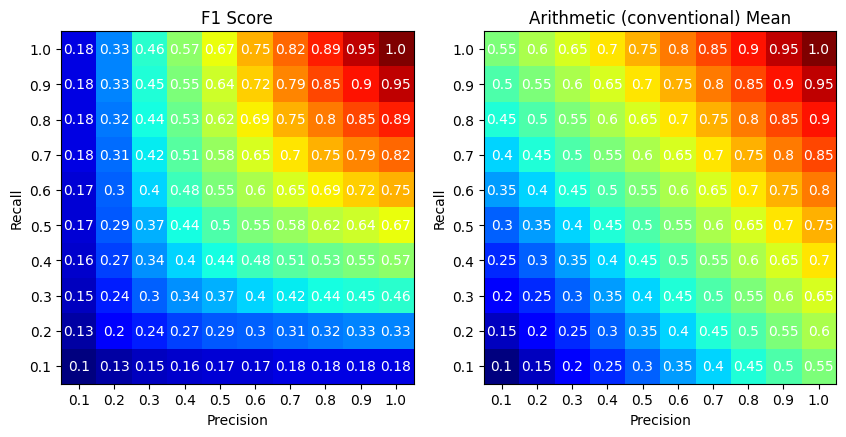

In [32]:
precision = np.round(np.linspace(0.1, 1, 10), 2)
recall = np.round(np.linspace(1, 0.1, 10), 2)

# create a mesh grid of precision and recall
precision_grid, recall_grid = np.meshgrid(precision, recall)

f1_score_calc = np.round(2 * (precision_grid * recall_grid) / (precision_grid + recall_grid), 2)
arithmetic_mean = np.round((precision_grid + recall_grid) / 2, 2)

# plot a color map of the F1 score
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)

im1 = axes[0].imshow(f1_score_calc, cmap="jet")
axes[0].set_xticks(np.arange(len(precision)), precision)
axes[0].set_yticks(np.arange(len(recall)), recall)
# Loop over data dimensions and create text annotations.
for i in range(len(precision)):
    for j in range(len(recall)):
        text = axes[0].text(j, i, f1_score_calc[i, j],
                       ha="center", va="center", color="w")
axes[0].set_xlabel("Precision")
axes[0].set_ylabel("Recall")
axes[0].set_title("F1 Score")

im2 = axes[1].imshow(arithmetic_mean, cmap="jet")
axes[1].set_xticks(np.arange(len(precision)), precision)
axes[1].set_yticks(np.arange(len(recall)), recall)
# Loop over data dimensions and create text annotations.
for i in range(len(precision)):
    for j in range(len(recall)):
        text = axes[1].text(j, i, arithmetic_mean[i, j],
                       ha="center", va="center", color="w")
axes[1].set_xlabel("Precision")
axes[1].set_ylabel("Recall")
axes[1].set_title("Arithmetic (conventional) Mean")


**What do these heatmaps mean?**

In both heatmaps, the colors represent the final calculated score. Deep blue signifies a very low score, while bright red indicates a high score approaching a perfect 1.0.

These maps compare two ways of combining Precision and Recall.

The Arithmetic Mean (right) gives a high score even if one metric is very poor while the other is high. It is an optimistic but potentially misleading average, showing yellow and green even when one axis is low.

The F1 Score (left) is the harmonic mean. It heavily punishes this imbalance. Notice the score stays low (blue/green) unless both Precision and Recall are high, concentrating the desirable red area in the top-right corner. This makes the F1 score a stricter, more realistic measure.

Text(0.5, 1.0, 'Arithmetic mean - F1 Score')

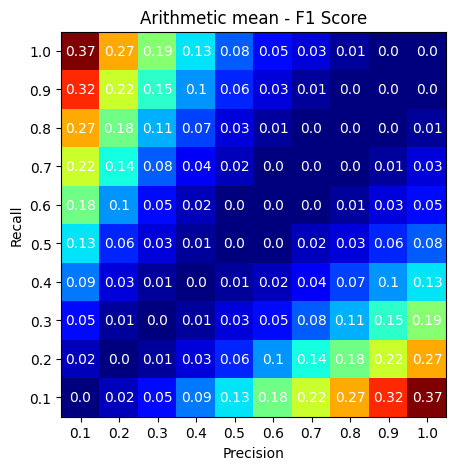

In [33]:
# plot a color map of the F1 score
fig, ax = plt.subplots(figsize=(5, 5), ncols=1)

diff = np.round(arithmetic_mean - f1_score_calc, 2)

im1 = ax.imshow(diff, cmap="jet")
ax.set_xticks(np.arange(len(precision)), precision)
ax.set_yticks(np.arange(len(recall)), recall)
# Loop over data dimensions and create text annotations.
for i in range(len(precision)):
    for j in range(len(recall)):
        text = ax.text(j, i, diff[i, j],
                       ha="center", va="center", color="w")
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.set_title("Arithmetic mean - F1 Score")


This heatmap shows how much the simple average (Arithmetic Mean) overestimates performance compared to the stricter F1 Score.

The bright red areas show the biggest difference. This occurs when there is a large imbalance between Precision and Recall, highlighting where the F1 score applies its greatest penalty.




### Precision/Recall Tradeoff, and the Decision Threshold

For a given trained classifier (without a new training), it is possible to increase the either the precision or the recall on the expense of the other. This is called the precision/recall tradeoff (note that a different classifier altogether could in principle increase both. The tradeoff is relevant only for a given classifier with a specific set of paramters).


Here, we will change the decision threshold of our binary classifier, which will change its precision and recall, without any additional training.

**To the student**: 
* Assume that you are developing an ML classifeir for medical diagnostics, with the propose of being a first indicator to identify whether a patient has a medical condition that requires treatment or not. Based on this result, the data wil be delivered to a medical professional or not (this might not be a great practice, but let's assume it for the sake of the example). What would be better, a high precision or a high recall? 
* Likewise, what would be better to optimize for (a high precision versus recall), when an ML classifier should highlight the best investment opportunities in a stock exchange?
* Add two more real-world cases in which:
  * Would a high recall will be desired, even on the expense of a lower precision? 
  * And when would a high precision will be preferred, on the expense of a lower recall? 


In [34]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-13489.14805779])

In Scikit-learn, the `decision_function` method is a method that is available for some classifiers, such as SVMs and logistic regression models. **It returns the "distance" of each data point to the decision boundary of the classifier.**

For binary classification, the decision boundary is a hyperplane that separates the two classes. The `decision_function` method returns the signed distance of each data point to this hyperplane. The sign of the distance indicates which side of the hyperplane the data point is on, and the magnitude of the distance indicates how far the data point is from the hyperplane.

For example, if the `decision_function` method returns a value of 2 for a particular data point, this means that the data point is on the positive side of the decision boundary and is 2 units away from the boundary. If the method returns a value of -1 for another data point, this means that the data point is on the negative side of the decision boundary and is 1 unit away from the boundary.

The `decision_function` method can be useful for analyzing the confidence of the classifier's predictions. Data points with larger absolute values of the decision function are farther from the decision boundary and are more confidently classified than data points with smaller absolute values.

A classification is made by comparing the decision function value to a threshold.
For instance:

In [35]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


Changing the threshold changes the prediction:

In [36]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [37]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [38]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

The SKLearn's [precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) function computes precision-recall pairs for different probability thresholds. 

* Note: this implementation is restricted to the binary classification task.
* The first precision and recall values are precision=class balance and recall=1.0 which corresponds to a classifier that always predicts the positive class.
* The last precision and recall values are 1. and 0. respectively and do not have a corresponding threshold. This ensures that the graph starts on the y axis.

In [39]:
print(precisions.shape)
print(recalls.shape)
print(thresholds.shape)

(60001,)
(60001,)
(60000,)


In [40]:
print(precisions[:5])
print(recalls[:5])
print(thresholds[:5])


[0.09035    0.09035151 0.09035301 0.09035452 0.09035602]
[1. 1. 1. 1. 1.]
[-146348.56726174 -142300.00705404 -137588.97581744 -137155.6264409
 -136254.05856216]


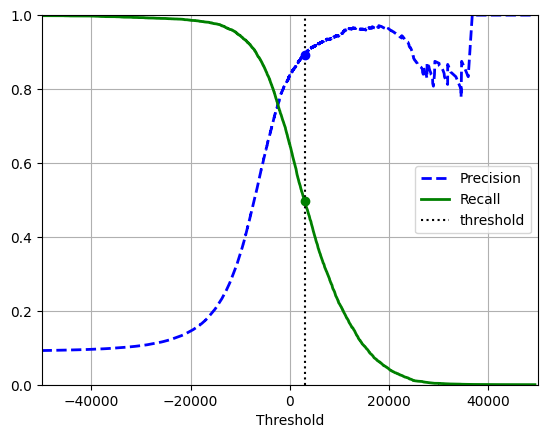

In [41]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

**To the student**: 
* How do precision and recall change with increasing or decreasing the threshold? 
* What is the intuition behind this behavior?

Below we use the same data, but to plot a Precision-Recall curve.
This is a useful curve for choosing a threshold. 

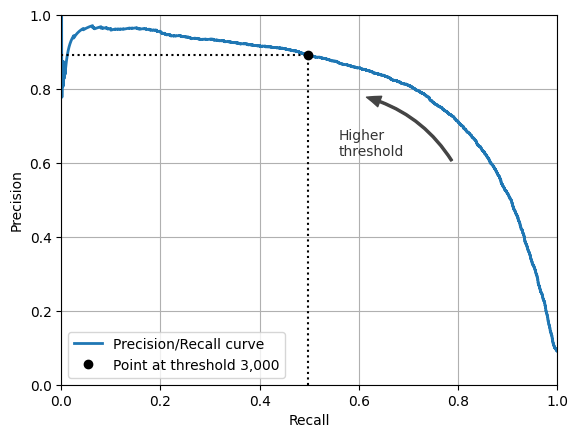

In [42]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

Let's find the threshold for a 90% precision:

In [43]:
idx_for_90_precision = (precisions >= 0.90).argmax()  # argmax returns the first index of the maximum value. In this case, the first True value.
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

To validate, we can now run predictions based on the classifier's scores and the new thresholds, and to re-calculate the precision:

In [44]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [45]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

And here is the recall for that threshold:

In [46]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## The ROC Curve

The Receiver Operating Characteristic (ROC) curve illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is the plot of the _true positive rate (TPR)_ against the _false positive rate (FPR)_, at various threshold settings ([Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)).

* **True Positive Rate (TPR)** - this is _recall_, also known as _sensitivity_: $TPR = Sensitivity = Recall = \frac{True \ Positives}{True \ Positives + False \ Negatives}$ ([Wikipedia](https://en.wikipedia.org/wiki/Sensitivity_and_specificity))
* **False Positive Rate (FPR)** - also known as "false alarm rate" or "fall-out": $FPR = \frac{False \ Positives}{False \ Positives + True \ Negatives}$ ([Wikipedia](https://en.wikipedia.org/wiki/False_positive_rate))

An ideal classifier would have a TPR=1 and a FPR=0.

The ROC curve was first developed by electrical engineers and radar engineers during World War II for detecting enemy objects in battlefields, starting in 1941, which led to its name ("receiver operating characteristic"). It was soon introduced to psychology to account for perceptual detection of stimuli. ROC analysis since then has been used in many other fields.

To calculate the ROC curve we use the `roc_curve` function by SKLearn ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html), [User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics0))

In [47]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

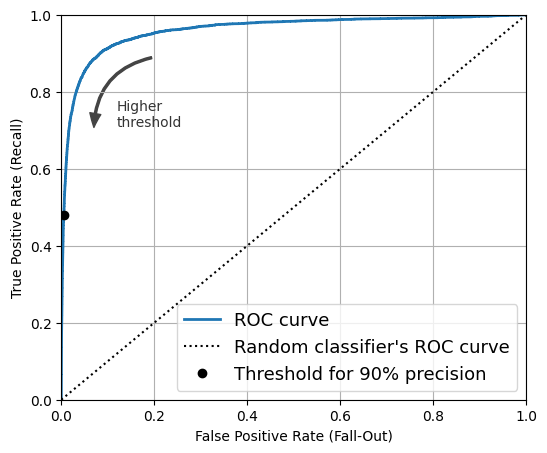

In [48]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.
We can calculate the Area Under the Curve (AUC) of the ROC curve, in order to see how 'resiliant' the classifier is for changing threshold. The larger the value, the more resiliant the classifier.

For this we can use the `roc_auc_score` function by SKLearn ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html))

In [49]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### ROC, Precision-Recall or Both - Which One to Use?
* Use Precision-Recall curve whenever the positive class is rare or when you care more about the false positives than the false negatives. 
* Otherwise, use the ROC curve. 

For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s; 10%) compared to the negatives (non-5s; 90%). In contrast, the precision-recall curve makes it clear that the classifier has room for improvement: the curve could really be closer to the top-right corner.

#### Comparison of Classifiers Based on Precision-Recall Curve

Below we define a new classifier, based on random forest. Without going into the intrinsic details of how it works, let's train it and evaluate its performance, compared to the `SGDClassifier` that we trained above.

**Warning:** the following cell may take a few minutes to run.

In [50]:
forest_clf = RandomForestClassifier(random_state=42)

We ask to return the prediction probabilities, instead of the actual binary prediction, such that we can have the option to set the class predictions using a threshold of our choice. This allows us to plot the precision-recall curve.

In [51]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Let's print the probabilities for the first two images in the training set, based on the cross validation process:

In [52]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

Check: Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positive images:

In [53]:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


With this probabilities we can plot the precision-recall curve

In [54]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

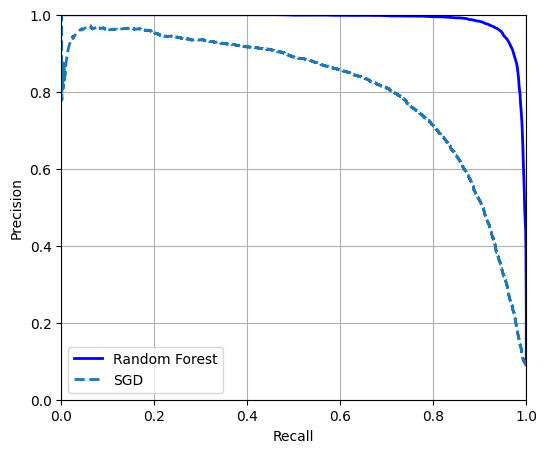

In [55]:
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

We could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [56]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [57]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [58]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [59]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

---
# Answer Sheet
The following sections contain answers to all "To the student" questions in this notebook.

## Question 1: Classification and Classifiers

**Summarize in your own words, based on the Wikipedia content quoted above, and potentially additional sources:**
* What are we trying to solve in a classification problem?
* What is a classifier?

### Answer 1

**What are we trying to solve in a classification problem?**

In a classification problem, we are trying to determine which category (or class) a given observation belongs to, based on its measurable properties (known as features). The core task is to take an input — described by a set of quantifiable characteristics — and assign it to one of a predefined set of categories.

For example, given an email's text content and metadata (the features), we want to decide whether it belongs to the "spam" or "non-spam" category. Similarly, given a patient's medical observations such as blood pressure, sex, and symptoms, we want to assign a diagnosis. In the MNIST dataset used in the notebook, the task is to look at pixel intensity values of a handwritten digit image and determine which digit (0 through 9) it represents — or, in the simplified binary version, whether the digit is a "5" or "not a 5."

Features used for classification can take many forms: categorical (e.g., blood type: A, B, AB, O), ordinal (e.g., size: small, medium, large), integer-valued (e.g., word frequency counts), or real-valued (e.g., blood pressure measurements). The classification algorithm must learn the relationship between these features and the target categories from labeled training data, and then generalize that knowledge to correctly categorize new, unseen observations.

**What is a classifier?**

A classifier is an algorithm (or its concrete implementation) that performs classification — that is, it takes input data and maps it to a predicted category. The term can refer to two related concepts:

1. **The algorithm or system**: The concrete implementation that accepts input features and produces a class prediction. For instance, the `SGDClassifier` used in the notebook is a classifier that trains a linear model using stochastic gradient descent and then predicts whether a digit image is a "5" or not.

2. **The mathematical function**: The underlying learned function that maps input data to a category. After training, a classifier has internalized a decision boundary (or decision function) that separates the feature space into regions corresponding to different classes. New observations are classified based on which region they fall into.

In practice, a classifier is trained on labeled examples (where the correct category is known), learns patterns that distinguish the categories, and then applies those patterns to assign categories to new, unlabeled observations.

## Question 2: Preprocessing — Boolean Values in `y_train_5`

* What does the Boolean values (`True` and `False`) stand for in the target `y_train_5`?
* Why wasn't `X` changed as well?

### Answer 2

**What does the Boolean values (`True` and `False`) stand for in the target `y_train_5`?**

In `y_train_5`, each Boolean value indicates whether the corresponding digit image is a `'5'` or not:

- `True` means the original label in `y_train` was `'5'` — this image belongs to the **positive class**.
- `False` means the original label was any other digit (`'0'` through `'4'`, or `'6'` through `'9'`) — this image belongs to the **negative class**.

This transformation converts the original 10-class multiclass problem into a simpler binary classification problem: "Is this digit a 5, or not?"

**Why wasn't `X` changed as well?**

`X` contains the feature data (the 784 pixel intensity values for each image). The features themselves do not change — the images are still the same images. What changed is only how we label them. We are simply re-framing the question we ask the model: instead of "which of 10 digits is this?", we now ask "is this a 5 or not?". The input data (pixel values) remains exactly the same; only the target labels needed to be transformed to reflect the new binary question.

## Question 3: The `predict` Result for `some_digit`

* Which image does `some_digit` stand for? (scroll above if needed)
* What is the meaning of the resulting Boolean value (`True` and `False`)?

### Answer 3

**Which image does `some_digit` stand for?**

`some_digit` is set to `X[2]`, the third image in the dataset. When plotted, it shows the handwritten digit **4**. Its true label is `y[2]`.

**What is the meaning of the resulting Boolean value (`True` and `False`)?**

The classifier returns `False` for this image, meaning it predicts that this digit is **not a 5**. Since the image is indeed a `4` (not a `5`), this is a correct prediction — specifically, a **True Negative**. If the classifier had returned `True`, it would have predicted the digit is a `5`.

## Question 4: The `cross_validate` Function

Regarding the `cross_validate` function:
* Describe in your own words what the `cv` argument is for.
* How many times has the model been trained?
* How is the value of `cv` related to the output of this function?
* What do `fit_time`, `score_time` and `test_score` stand for?

### Answer 4

**Describe in your own words what the `cv` argument is for.**

The `cv` argument specifies the cross-validation splitting strategy. When `cv=3`, the training data is divided into 3 equal-sized, non-overlapping subsets called "folds." The model is then trained and evaluated 3 times: each time, one fold is held out as the validation (test) set, and the remaining two folds are used for training. This rotation ensures every data point is used for validation exactly once, providing a more reliable and less biased estimate of model performance than a single train/test split.

**How many times has the model been trained?**

The model has been trained **3 times** — once per fold. In each iteration, the model is trained from scratch on 2 of the 3 folds and evaluated on the remaining fold.

**How is the value of `cv` related to the output of this function?**

The value of `cv` determines the number of elements in each output array. Since `cv=3`, each array in the output dictionary (`fit_time`, `score_time`, `test_score`) contains exactly 3 values — one result from each of the 3 cross-validation iterations.

**What do `fit_time`, `score_time` and `test_score` stand for?**

- **`fit_time`**: An array of the time (in seconds) it took to train the model for each fold. For example, `[5.56, 4.98, 3.97]` means the first fold took ~5.56 seconds to train.
- **`score_time`**: An array of the time (in seconds) it took to evaluate (score) the model on the validation fold. This measures only prediction and metric computation time, not training time.
- **`test_score`**: An array of the accuracy scores achieved on the held-out validation fold for each iteration. The values `[0.95035, 0.96035, 0.9604]` mean the model correctly classified approximately 95–96% of the samples in each validation fold.

## Question 5: Interpreting Accuracy

* Could you provide a textual description of the accuracy result for the first fold?
* Given the uniform distribution of samples across all 10 digits, what would be a simple handwritten rule to achieve 90% accuracy?
* How would you describe the goodness of classification of the `SGDClassifier` versus the expected accuracy of such a handwritten rule?

### Answer 5

**Textual description of the accuracy result for the first fold:**

The accuracy for the first fold is 0.95035. Since each fold contains 20,000 samples (60,000 / 3), this means: out of 20,000 digit images, approximately **19,007 were correctly predicted** (either correctly identified as `5` or correctly identified as not `5`), while approximately **993 were incorrectly predicted** (either a `5` missed by the model, or a non-`5` wrongly labeled as `5`).

**Simple handwritten rule to achieve 90% accuracy:**

A simple rule would be: **"Always predict 'not 5' for every image."** Since the digit `5` makes up only about 10% of the dataset (1 out of 10 equally distributed digits), the remaining 90% are non-`5` digits. By always predicting `False` (not a `5`), this naive rule would be correct 90% of the time, achieving ~90% accuracy — without ever looking at the image features.

**Goodness of SGDClassifier vs. the handwritten rule:**

The `SGDClassifier` achieves approximately 95–96% accuracy, which is only about 5–6 percentage points above the naive "always predict not-5" rule at ~90%. While the SGD model clearly learned something meaningful from the features, the high baseline accuracy of the naive rule reveals that accuracy alone is a misleading metric for imbalanced binary classification problems. The seemingly high accuracy of 95% is less impressive when we realize that a trivial rule that ignores all features already gets 90%.

## Question 6: DummyClassifier Accuracy

* What is the accuracy of the `DummyClassifier`?
* How does it compare to the handwritten rule you suggested above, and to the `SGDClassifier`?

### Answer 6

**What is the accuracy of the `DummyClassifier`?**

The `DummyClassifier` achieves an accuracy of **0.90965 (~91%)** across all three folds. This is because it always predicts `False` (not a `5`), and since approximately 90.965% of the training samples are indeed not `5`, it gets that proportion correct by default.

**How does it compare to the handwritten rule and the `SGDClassifier`?**

The `DummyClassifier`'s accuracy (~91%) is essentially identical to the simple handwritten rule of "always predict not-5," confirming that both strategies are equivalent — they ignore the input features entirely and rely solely on the class imbalance. The `SGDClassifier` at ~95–96% accuracy outperforms both, demonstrating that it has genuinely learned to identify the digit `5` from the pixel features. However, the small gap (only ~5 percentage points) between a model that actually analyzes images and one that blindly guesses highlights why accuracy alone is insufficient for evaluating classifiers on imbalanced datasets. Additional metrics like precision, recall, and F1-score are needed.

## Question 7: Exercise — Fashion-MNIST Data Set

Follow the same process used to analyze the MNIST data set, but this time do it using the **Fashion-MNIST** data set.
- Get the data set
- Preprocess the data set
- Train a model
- Evaluate the model

> Are you able to replicate the process? Provide your insights.

### Answer 7

The Fashion-MNIST dataset has the same structure as MNIST: 70,000 grayscale 28x28 images split into 60,000 training and 10,000 test samples, with 10 classes. The classes represent clothing items instead of digits: T-shirt/top (0), Trouser (1), Pullover (2), Dress (3), Coat (4), Sandal (5), Shirt (6), Sneaker (7), Bag (8), Ankle boot (9).

**Preprocessing** follows the same pattern:

```python
X_train_f, X_test_f = X_fashion[:60000], X_fashion[60000:]
y_train_f, y_test_f = y_fashion[:60000], y_fashion[60000:]

# Binary classification: "Is it a Sandal (label '5') or not?"
y_train_sandal = (y_train_f == '5')
y_test_sandal = (y_test_f == '5')
```

**Training** uses the same SGDClassifier:

```python
sgd_fashion = SGDClassifier(random_state=42)
sgd_fashion.fit(X_train_f, y_train_sandal)
```

**Evaluation** via cross-validation:

```python
cross_validate(estimator=sgd_fashion, X=X_train_f, y=y_train_sandal, cv=3, scoring="accuracy")
```

**Insights**: The process is fully replicable because Fashion-MNIST was intentionally designed as a drop-in replacement for MNIST with the same data format. However, Fashion-MNIST is generally considered a harder classification task — clothing items share more visual similarity with each other than handwritten digits do (e.g., pullovers vs. coats, shirts vs. T-shirts). We would expect the SGDClassifier to achieve similar accuracy on the binary "sandal vs. not-sandal" task (since class balance is the same at ~10%), but precision and recall may differ depending on how visually distinct sandals are from other clothing items. A DummyClassifier would again achieve ~90% accuracy, reinforcing the lesson that accuracy is misleading for imbalanced binary problems.

## Question 8: Confusion Matrix

Using `sklearn` resources about Confusion Matrix:
* What are the required arguments that the `confusion_matrix` function expects?
* What is the output of this function, specifically for a binary classifier such as the one tested here?
* What is the meaning of each value in both of the confusion matrices returned above?

### Answer 8

**What are the required arguments that the `confusion_matrix` function expects?**

The `confusion_matrix` function requires two arguments:
1. **`y_true`**: The ground-truth (actual) labels — what the correct classification is for each sample.
2. **`y_pred`**: The predicted labels — what the classifier predicted for each sample.

Both must be array-like and of the same length. There are also optional parameters such as `labels` (to specify the order of classes) and `normalize`.

**What is the output of this function, specifically for a binary classifier?**

For a binary classifier, the output is a **2x2 NumPy array**. In sklearn's default ordering (sorted labels: `False` first, `True` second), the matrix is laid out as:

|                      | Predicted Negative | Predicted Positive |
|----------------------|-------------------:|-------------------:|
| **Actual Negative**  | True Negatives (TN)| False Positives (FP)|
| **Actual Positive**  | False Negatives (FN)| True Positives (TP)|

**What is the meaning of each value in both confusion matrices?**

**SGD Classifier confusion matrix:**
```
[[53892,   687],
 [ 1891,  3530]]
```
- **53,892 (TN)**: Non-`5` digits correctly predicted as not `5`.
- **687 (FP)**: Non-`5` digits incorrectly predicted as `5` (false alarms).
- **1,891 (FN)**: Actual `5`s incorrectly predicted as not `5` (missed detections).
- **3,530 (TP)**: Actual `5`s correctly predicted as `5`.
- Total: 53,892 + 687 + 1,891 + 3,530 = 60,000 samples.

**Perfect predictions confusion matrix:**
```
[[54579,     0],
 [    0,  5421]]
```
- **54,579 (TN)**: All non-`5` digits correctly identified — no false positives.
- **0 (FP)**: No non-`5` digit was wrongly called a `5`.
- **0 (FN)**: No actual `5` was missed.
- **5,421 (TP)**: All `5`s correctly identified.
- This represents a perfect classifier with zero errors.

## Question 9: Exercise — Precision and Recall for the Autonomous Security Drone

**Scenario:** 500 camera views, 10 actual persons present, drone raised 12 alarms, 8 correct alarms (TP), 4 false alarms (FP), 2 missed persons (FN), 488 correct non-alarms (TN).

> Calculate the Precision and the Recall. Show the fractions used.

> Explain what the calculated values mean.

### Answer 9

**Calculating the Metrics:**

**Precision** = TP / (TP + FP) = 8 / (8 + 4) = **8/12 = 0.667 (66.7%)**

**Recall** = TP / (TP + FN) = 8 / (8 + 2) = **8/10 = 0.80 (80%)**

**Explaining the Results:**

- **Precision of 66.7%** means that when the drone sounds an alarm claiming a person is present, it is correct only about two-thirds of the time. One out of every three alarms is a false alarm (triggered by shadows, falling boxes, etc.). Security personnel responding to these alarms would waste effort on false triggers about 33% of the time.

- **Recall of 80%** means the drone successfully detects 8 out of the 10 actual intrusions. However, it misses 2 out of 10 real persons (20% go undetected). For a security system, this is concerning — a missed intruder could lead to a security breach. Depending on the risk tolerance, the company may want to tune the system to achieve higher recall (even if it means more false alarms), since missing a real intruder is likely more costly than responding to a false alarm.

## Question 10: Manual Recall Calculation

* Similar to the manual calculation of precision, write down the Python code for calculating recall.

### Answer 10

In [60]:
# Recall: TP / (TP + FN)
# From the confusion matrix cm:
#   cm[1, 1] = TP (True Positives)  = 3530
#   cm[1, 0] = FN (False Negatives) = 1891
cm[1, 1] / (cm[1, 0] + cm[1, 1])
# Result: 0.6511713705958311 — matches recall_score(y_train_5, y_train_pred)

np.float64(0.6511713705958311)

## Question 11: Manual F1 Score Calculation

* Using the definition, calculate the F1 score using True Positives (TP), False Negatives (FN) and False Positives (FP). Write this as Python code.

### Answer 11

In [61]:
# From the confusion matrix:
TP = cm[1, 1]  # 3530
FN = cm[1, 0]  # 1891
FP = cm[0, 1]  # 687

# F1 = TP / (TP + (FP + FN) / 2)
f1 = TP / (TP + (FP + FN) / 2)
f1
# Result: 0.7325171197343847 — matches f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

## Question 12: Precision vs. Recall — Real-World Tradeoffs

* For medical diagnostics (first indicator for a condition): high precision or high recall?
* For highlighting best investment opportunities in a stock exchange: high precision or high recall?
* Add two more real-world cases:
  * When would high recall be desired, even at the expense of lower precision?
  * When would high precision be preferred, at the expense of lower recall?

### Answer 12

**Medical diagnostics (first indicator for a condition): High precision or high recall?**

**High recall** is better here. In medical diagnostics used as a first screening indicator, missing a patient who actually has the condition (a False Negative) is far more dangerous than flagging a healthy patient for further review (a False Positive). A false negative means the patient may not receive necessary treatment, potentially leading to worsening health or death. A false positive simply means an additional follow-up test with a medical professional, which is a much lower cost. Therefore, we want the system to catch as many true positive cases as possible, even if it means some false alarms.

**Stock exchange — highlighting best investment opportunities: High precision or high recall?**

**High precision** is better here. When a system recommends a stock as a good investment, investors want to be confident that the recommendation is correct. A false positive (recommending a bad stock) directly leads to financial loss. A false negative (missing a good stock) is a missed opportunity but does not cause direct harm. Investors would rather receive fewer but more reliable recommendations than be flooded with unreliable ones.

**Two additional real-world cases:**

**High recall preferred (at the expense of precision):**
- **Airport security screening**: When scanning luggage for prohibited or dangerous items, it is critical to catch every actual threat (high recall). A false alarm means an extra manual bag inspection (inconvenient but safe). A missed threat (false negative) could have catastrophic consequences. The system should err heavily on the side of caution.

**High precision preferred (at the expense of recall):**
- **Email spam filtering**: When a spam filter marks an email as spam, users want it to be right. A false positive (a legitimate email sent to the spam folder) can cause a user to miss an important message — a job offer, a client email, or a critical notification. A false negative (a spam email reaching the inbox) is merely an annoyance. Users would rather see a few spam emails in their inbox than risk losing important messages.

## Question 13: Precision/Recall Behavior with Changing Threshold

* How do precision and recall change with increasing or decreasing the threshold?
* What is the intuition behind this behavior?

### Answer 13

**How do precision and recall change with increasing or decreasing the threshold?**

- **Increasing the threshold**: Precision **increases** while recall **decreases**. With a higher threshold, the classifier becomes more selective — it only predicts "positive" when it is very confident. This means fewer false positives (boosting precision), but more actual positives are missed because the bar for a positive prediction is too high (lowering recall).

- **Decreasing the threshold**: Recall **increases** while precision **decreases**. With a lower threshold, the classifier predicts "positive" more liberally. This catches more actual positives (boosting recall), but also lets in more false positives since the classifier is less discriminating (lowering precision).

**What is the intuition behind this behavior?**

The decision threshold controls how "sure" the classifier needs to be before it labels a sample as positive. Think of it as a confidence dial:

- **High threshold (strict)**: The classifier says "I'll only call something a 5 if I'm very sure." This means when it does say "5," it's usually right (high precision), but it stays silent on many actual 5s that it's not confident enough about (low recall).

- **Low threshold (lenient)**: The classifier says "I'll call anything a 5 if there's even a small chance." This catches nearly all actual 5s (high recall), but it also mistakenly labels many non-5s as 5s (low precision).

This is the fundamental **precision/recall tradeoff**: for a given trained model, you cannot improve one without sacrificing the other. The precision-recall curve visualizes all possible tradeoff points, and the threshold selection depends on the application's priorities (as discussed in Question 12).